# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [3]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [4]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

In [5]:
print X_test.shape

(1000, 32, 32, 3)


## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [6]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]

In [16]:
first_features = []
test = X_train[0].squeeze()
print test.shape
for feature in feature_fns:
    feats = feature(X_train[0].squeeze())
    first_features.append(feats)
print feats.size
print len(first_features)

(32, 32, 3)
10
2


In [3]:
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [72]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-8, 0.5e-8, 1.5e-8]
regularization_strengths = [1e6, 1.5e6, 0.5e6]

results = {}
best_val = -1
best_svm = None

X_train_feats = np.reshape(X_train_feats, (X_train.shape[0], -1))
X_val_feats = np.reshape(X_val_feats, (X_val.shape[0], -1))
X_test_feats = np.reshape(X_test_feats, (X_test.shape[0], -1))
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        svmobj = LinearSVM()
        svmobj.train(X_train_feats, y_train, learning_rate = lr, reg = reg, num_iters=1000, verbose=True)
        val_preds = svmobj.predict(X_val_feats)
        train_preds = svmobj.predict(X_train_feats)
        val_acc = np.mean(val_preds == y_val)
        train_acc = np.mean(train_preds == y_train)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svmobj
        results[(lr, reg)] = (train_acc, val_acc)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 1000: loss 796.882051
iteration 100 / 1000: loss 114.560834
iteration 200 / 1000: loss 23.143184
iteration 300 / 1000: loss 10.894435
iteration 400 / 1000: loss 9.253716
iteration 500 / 1000: loss 9.033944
iteration 600 / 1000: loss 9.004527
iteration 700 / 1000: loss 9.000565
iteration 800 / 1000: loss 9.000046
iteration 900 / 1000: loss 8.999972
iteration 0 / 1000: loss 1199.932663
iteration 100 / 1000: loss 66.961737
iteration 200 / 1000: loss 11.820636
iteration 300 / 1000: loss 9.137333
iteration 400 / 1000: loss 9.006665
iteration 500 / 1000: loss 9.000302
iteration 600 / 1000: loss 8.999994
iteration 700 / 1000: loss 8.999973
iteration 800 / 1000: loss 8.999972
iteration 900 / 1000: loss 8.999979
iteration 0 / 1000: loss 400.018821
iteration 100 / 1000: loss 152.487173
iteration 200 / 1000: loss 61.648902
iteration 300 / 1000: loss 28.321768
iteration 400 / 1000: loss 16.087595
iteration 500 / 1000: loss 11.601175
iteration 600 / 1000: loss 9.954772
iteration 700 /

In [73]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.408


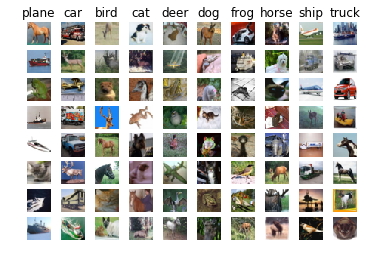

In [74]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

X_test = np.reshape(X_test, (1000, 32, 32, 3))
examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [75]:
print X_train_feats.shape

(49000, 155)


In [79]:
best_net = None # store the best model into this 
max_acc = -1
learning_rates = [0.25, 0.35]
regularization_strengths = [0.001, 0.0005, 0.002]
#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
for l in learning_rates:
    for r in regularization_strengths:
                inp_size = X_train_feats.shape[1]
                hid_size = 512
                num_class = 10
                net = TwoLayerNet(inp_size, hid_size, num_class)

                stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                            num_iters=2500, batch_size=200,
                            learning_rate=l, learning_rate_decay=0.95,
                            reg=r, verbose=True)

                # Predict on the validation set
                val_acc = (net.predict(X_val_feats) == y_val).mean()
                if val_acc > max_acc:
                    max_acc = val_acc
                    best_net = net
                print 'Validation accuracy: ', val_acc

print 'Best Validation Accuray is ', max_acc
print 'Learning rate for best net', net.learning_rate
print 'Regularization Strength', net.reg
print 'Batch Size', net.batch_size
print 'Hidden layer size', net.hidden_size

iteration 0 / 2500: loss 2.302585
iteration 100 / 2500: loss 1.876634
iteration 200 / 2500: loss 1.443104
iteration 300 / 2500: loss 1.333263
iteration 400 / 2500: loss 1.348774
iteration 500 / 2500: loss 1.421602
iteration 600 / 2500: loss 1.124483
iteration 700 / 2500: loss 1.275246
iteration 800 / 2500: loss 1.305822
iteration 900 / 2500: loss 1.256911
iteration 1000 / 2500: loss 1.331737
iteration 1100 / 2500: loss 1.249841
iteration 1200 / 2500: loss 1.308779
iteration 1300 / 2500: loss 1.187699
iteration 1400 / 2500: loss 1.148061
iteration 1500 / 2500: loss 1.194831
iteration 1600 / 2500: loss 1.229462
iteration 1700 / 2500: loss 1.058574
iteration 1800 / 2500: loss 1.181780
iteration 1900 / 2500: loss 1.195886
iteration 2000 / 2500: loss 1.038790
iteration 2100 / 2500: loss 1.130195
iteration 2200 / 2500: loss 1.070285
iteration 2300 / 2500: loss 1.151228
iteration 2400 / 2500: loss 1.043394
Validation accuracy:  0.597
iteration 0 / 2500: loss 2.302585
iteration 100 / 2500: los

In [81]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print test_acc

0.577


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!